In [ ]:
from google.colab import drive

# Bağlantı oluştur
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# Mevcut çalışma dizinini göster
current_directory = os.getcwd()
print("Mevcut Dizin:", current_directory)

Mevcut Dizin: /content


In [ ]:
import os
os.chdir("/content/drive/My Drive/PCA_MLP_MNIST")

In [8]:
# 1) model has been created without tenserflow or keras, just used for mnist dataset.




import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Veri çekme ve ön işleme için TensorFlow'u kullanma
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Sadece TensorFlow'u veri çekme ve ön işleme için kullan
# Geri kalan işlemleri numpy ile gerçekleştir
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def categorical_crossentropy(predictions, targets):
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    N = predictions.shape[0]
    cross_entropy = -np.sum(targets * np.log(predictions + 1e-9)) / N
    return cross_entropy

def accuracy(predictions, targets):
    predicted_labels = np.argmax(predictions, axis=-1)
    true_labels = np.argmax(targets, axis=-1)
    correct_predictions = np.sum(predicted_labels == true_labels)
    total_samples = predictions.shape[0]
    return correct_predictions / total_samples

# Modeli oluşturma
input_size = 28 * 28
hidden_size1 = 128
hidden_size2 = 64
output_size = 10

weights_input_hidden1 = np.random.randn(input_size, hidden_size1)
biases_input_hidden1 = np.zeros((1, hidden_size1))

weights_hidden1_hidden2 = np.random.randn(hidden_size1, hidden_size2)
biases_hidden1_hidden2 = np.zeros((1, hidden_size2))

weights_hidden2_output = np.random.randn(hidden_size2, output_size)
biases_hidden2_output = np.zeros((1, output_size))

# Modeli eğitme
learning_rate = 0.01
epochs = 12
batch_size = 32

for epoch in range(epochs):
    for i in range(0, len(train_images), batch_size):
        # İleri yayılım
        batch_images = train_images[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]

        hidden_input1 = np.dot(batch_images, weights_input_hidden1) + biases_input_hidden1
        hidden_output1 = sigmoid(hidden_input1)

        hidden_input2 = np.dot(hidden_output1, weights_hidden1_hidden2) + biases_hidden1_hidden2
        hidden_output2 = sigmoid(hidden_input2)

        output_input = np.dot(hidden_output2, weights_hidden2_output) + biases_hidden2_output
        output_predictions = softmax(output_input)

        # Loss hesaplama
        loss = categorical_crossentropy(output_predictions, batch_labels)

        # Accuracy hesaplama
        acc = accuracy(output_predictions, batch_labels)

        # Geri yayılım
        output_error = output_predictions - batch_labels
        hidden2_error = np.dot(output_error, weights_hidden2_output.T) * hidden_output2 * (1 - hidden_output2)
        hidden1_error = np.dot(hidden2_error, weights_hidden1_hidden2.T) * hidden_output1 * (1 - hidden_output1)

        # Parametre güncelleme
        weights_hidden2_output -= learning_rate * np.dot(hidden_output2.T, output_error) / len(batch_images)
        biases_hidden2_output -= learning_rate * np.sum(output_error, axis=0, keepdims=True) / len(batch_images)

        weights_hidden1_hidden2 -= learning_rate * np.dot(hidden_output1.T, hidden2_error) / len(batch_images)
        biases_hidden1_hidden2 -= learning_rate * np.sum(hidden2_error, axis=0, keepdims=True) / len(batch_images)

        weights_input_hidden1 -= learning_rate * np.dot(batch_images.T, hidden1_error) / len(batch_images)
        biases_input_hidden1 -= learning_rate * np.sum(hidden1_error, axis=0, keepdims=True) / len(batch_images)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {acc:.4f}")


Epoch 1/12 - Loss: 1.8103 - Accuracy: 0.3750
Epoch 2/12 - Loss: 1.3061 - Accuracy: 0.4688
Epoch 3/12 - Loss: 1.0468 - Accuracy: 0.5938
Epoch 4/12 - Loss: 0.8960 - Accuracy: 0.6250
Epoch 5/12 - Loss: 0.7920 - Accuracy: 0.7188
Epoch 6/12 - Loss: 0.7153 - Accuracy: 0.7188
Epoch 7/12 - Loss: 0.6569 - Accuracy: 0.7500
Epoch 8/12 - Loss: 0.6098 - Accuracy: 0.8125
Epoch 9/12 - Loss: 0.5705 - Accuracy: 0.8125
Epoch 10/12 - Loss: 0.5371 - Accuracy: 0.8438
Epoch 11/12 - Loss: 0.5084 - Accuracy: 0.8438
Epoch 12/12 - Loss: 0.4838 - Accuracy: 0.8438


In [4]:
# 2) i have used the same model of first section, but i also used PCA inside of the mnist dataset.

import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Veriyi yükleme
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Veriyi düzleştirme
train_images = train_images.reshape((60000, 28 * 28)).astype('float32')/255
test_images = test_images.reshape((10000, 28 * 28)).astype('float32')/255


train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Veriyi normalize etme
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)


# PCA modelini oluştur
pca = PCA(n_components=0.95)  # Toplam varyansın %95'ini korumak için yeterli bileşeni seç
pca.fit(train_images)

# Eğitim ve test verilerini PCA ile dönüştürme
train_images = pca.transform(train_images)
test_images = pca.transform(test_images)

# PCA ile elde edilen özellik sayısını kontrol etme
num_features = train_images.shape[1]
print("PCA ile elde edilen özellik sayısı:", num_features)


import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def categorical_crossentropy(predictions, targets):
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    N = predictions.shape[0]
    cross_entropy = -np.sum(targets * np.log(predictions + 1e-9)) / N
    return cross_entropy

def accuracy(predictions, targets):
    predicted_labels = np.argmax(predictions, axis=-1)
    true_labels = np.argmax(targets, axis=-1)
    correct_predictions = np.sum(predicted_labels == true_labels)
    total_samples = predictions.shape[0]
    return correct_predictions / total_samples



# Modeli oluşturma
input_size = num_features
hidden_size1 = 128
hidden_size2 = 64
output_size = 10

weights_input_hidden1 = np.random.randn(input_size, hidden_size1)
biases_input_hidden1 = np.zeros((1, hidden_size1))

weights_hidden1_hidden2 = np.random.randn(hidden_size1, hidden_size2)
biases_hidden1_hidden2 = np.zeros((1, hidden_size2))

weights_hidden2_output = np.random.randn(hidden_size2, output_size)
biases_hidden2_output = np.zeros((1, output_size))

# Modeli eğitme
learning_rate = 0.01
epochs = 12
batch_size = 32

for epoch in range(epochs):
    for i in range(0, len(train_images), batch_size):
        # İleri yayılım
        batch_images = train_images[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]

        hidden_input1 = np.dot(batch_images, weights_input_hidden1) + biases_input_hidden1
        hidden_output1 = sigmoid(hidden_input1)

        hidden_input2 = np.dot(hidden_output1, weights_hidden1_hidden2) + biases_hidden1_hidden2
        hidden_output2 = sigmoid(hidden_input2)

        output_input = np.dot(hidden_output2, weights_hidden2_output) + biases_hidden2_output
        output_predictions = softmax(output_input)

        # Loss hesaplama
        loss = categorical_crossentropy(output_predictions, batch_labels)

        # Accuracy hesaplama
        acc = accuracy(output_predictions, batch_labels)

        # Geri yayılım
        output_error = output_predictions - batch_labels
        hidden2_error = np.dot(output_error, weights_hidden2_output.T) * hidden_output2 * (1 - hidden_output2)
        hidden1_error = np.dot(hidden2_error, weights_hidden1_hidden2.T) * hidden_output1 * (1 - hidden_output1)

        # Parametre güncelleme
        weights_hidden2_output -= learning_rate * np.dot(hidden_output2.T, output_error) / len(batch_images)
        biases_hidden2_output -= learning_rate * np.sum(output_error, axis=0, keepdims=True) / len(batch_images)

        weights_hidden1_hidden2 -= learning_rate * np.dot(hidden_output1.T, hidden2_error) / len(batch_images)
        biases_hidden1_hidden2 -= learning_rate * np.sum(hidden2_error, axis=0, keepdims=True) / len(batch_images)

        weights_input_hidden1 -= learning_rate * np.dot(batch_images.T, hidden1_error) / len(batch_images)
        biases_input_hidden1 -= learning_rate * np.sum(hidden1_error, axis=0, keepdims=True) / len(batch_images)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {acc:.4f}")








PCA ile elde edilen özellik sayısı: 331


<ipython-input-4-e319b9ae451f>:47: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/12 - Loss: 2.0254 - Accuracy: 0.2500
Epoch 2/12 - Loss: 1.1891 - Accuracy: 0.5000
Epoch 3/12 - Loss: 0.9063 - Accuracy: 0.6875
Epoch 4/12 - Loss: 0.7566 - Accuracy: 0.7188
Epoch 5/12 - Loss: 0.6606 - Accuracy: 0.7812
Epoch 6/12 - Loss: 0.5938 - Accuracy: 0.8125
Epoch 7/12 - Loss: 0.5438 - Accuracy: 0.8750
Epoch 8/12 - Loss: 0.5044 - Accuracy: 0.8750
Epoch 9/12 - Loss: 0.4725 - Accuracy: 0.8750
Epoch 10/12 - Loss: 0.4465 - Accuracy: 0.8750
Epoch 11/12 - Loss: 0.4249 - Accuracy: 0.9062
Epoch 12/12 - Loss: 0.4068 - Accuracy: 0.9062


Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6430 - accuracy: 0.8299 - val_loss: 0.3182 - val_accuracy: 0.9113
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3011 - accuracy: 0.9136 - val_loss: 0.2549 - val_accuracy: 0.9281
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2495 - accuracy: 0.9280 - val_loss: 0.2289 - val_accuracy: 0.9325
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2158 - accuracy: 0.9379 - val_loss: 0.1951 - val_accuracy: 0.9407
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1901 - accuracy: 0.9458 - val_loss: 0.1757 - val_accuracy: 0.9464
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1695 - accuracy: 0.9514 - val_loss: 0.1643 - val_accuracy: 0.9492
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1531 - accuracy: 0.9560 - val_loss: 0.1480 - val_accuracy:

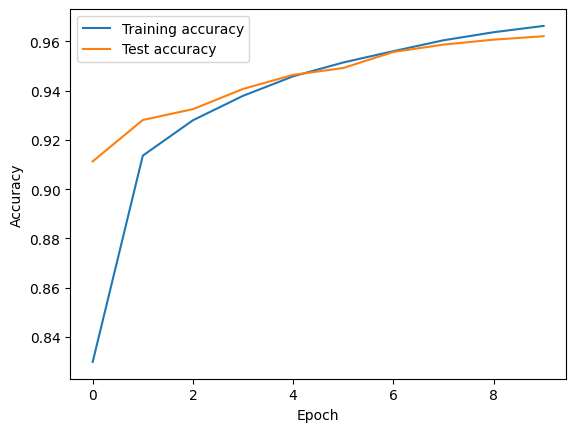

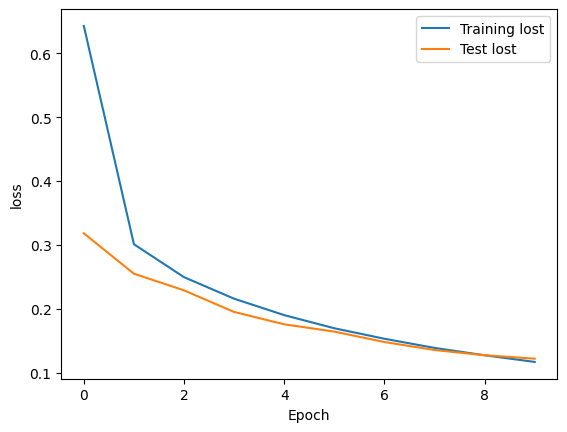

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# MNIST veri seti
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Veri normalize
train_images, test_images = train_images / 255.0, test_images / 255.0

# Modeli oluştur
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Modeli derleyelim
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Modeli eğitelim
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))


import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Training lost')
plt.plot(history.history['val_loss'], label='Test lost')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
